In [ ]:
from transformers import BertForTokenClassification, AutoTokenizer
from transformers import BertForSequenceClassification
import json
import torch


ner_model_path = "../models/ner_model"
ner_model = BertForTokenClassification.from_pretrained(ner_model_path)
tokenizer_ner = AutoTokenizer.from_pretrained(ner_model_path)


re_model_path = "../models/re_model"
re_model = BertForSequenceClassification.from_pretrained(re_model_path)
tokenizer_re = AutoTokenizer.from_pretrained(re_model_path)

label_map_ner = {
    0: "B-CHARACTER",
    1: "B-HOUSE",
    2: "B-LOCATION",
    3: "B-MAGIC_ITEM",
    4: "B-SPELL",
    5: "I-CHARACTER",
    6: "I-HOUSE",
    7: "I-LOCATION",
    8: "I-MAGIC_ITEM",
    9: "I-SPELL",
    10: "O"
  }

label_map_re = {0: 'acquires',
 1: 'ally-of',
 2: 'casts',
 3: 'enemy-of',
 4: 'founder-of-house',
 5: 'friend-of',
 6: 'given_to',
 7: 'gives',
 8: 'knows',
 9: 'located_in',
 10: 'member-of-house',
 11: 'mentor-of',
 12: 'no_relation',
 13: 'owns',
 14: 'parent-of',
 15: 'rival-of',
 16: 'sibling-of',
 17: 'student-of',
 18: 'teaches',
 19: 'uses'}


/home/mkdsp/Desktop/HarryPotter/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def spoji(tokens, start,end)->str:
    text = " ".join(tokens[start:end+1])
    return text.replace(' ##','')

def daj_entitete(text: str) -> dict:
    resenje = {}
    ner_model.eval()

    inputs = tokenizer_ner(text, return_tensors="pt", truncation=True, is_split_into_words=False)

    with torch.no_grad():
        outputs = ner_model(**inputs)
    
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=2)

    tokens = tokenizer_ner.convert_ids_to_tokens(inputs["input_ids"][0])[1:-1]
    predicted_labels = [label_map_ner[pred.item()] for pred in predictions[0]][1:-1]

    resenje['tokens'] = tokens
    lista_entiteta = []

    # for token, label in zip(tokens, predicted_labels):
    #     print(f"{token:15} -> {label}")

    i = 0
    id = 0
    while i < len(tokens):
        label = predicted_labels[i]
        if label.startswith("B-"):
            ent_type = label[2:]
            start = i
            end = i
            i += 1
            while i < len(tokens) and predicted_labels[i].startswith("I-"):
                end = i
                i += 1
            
            lista_entiteta.append({
                'id': id,
                'text': spoji(tokens,start,end),
                'type': ent_type,
                'token_start': start,
                'token_end': end
            })
            id+=1
        else:
            i += 1

    resenje['entities'] = lista_entiteta
    return resenje


In [3]:
# daj_entitete('Harry Potter defeated Jhon Arbakl using his magic cloak')

In [4]:
def daj_relaciju(text : list) -> str:
    re_model.eval() 
    inputs = tokenizer_re(text, return_tensors="pt", truncation=True,is_split_into_words=True)
    with torch.no_grad():
        outputs = re_model(**inputs)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)

    return label_map_re[predictions.item()]

In [5]:
# daj_relaciju("[E1:CHARACTER] Harry Potter [/E1] is casting Avakedabra with his [E2:SPELL] wand[/E2].")

In [6]:

def daj_sve(text :str) -> dict:
    def umetni(token_start, token_end, typee, num, tokens):
        tokens.insert(token_end+1, f'[/E{num}]')
        tokens.insert(token_start, f'[E{num}:{typee}]')
        return tokens

    entities = daj_entitete(text)
    tokens = entities['tokens']

    relations = []

    for i, ent1 in enumerate(entities['entities']):
            if ent1['type'] != 'CHARACTER':
                continue
            
            # Compare with all other entities
            for j, ent2 in enumerate(entities['entities']):
                if i == j:
                    continue
                tokeni = tokens.copy()

                token_start_ent1 = ent1.get('token_start', None)
                token_end_ent1 = ent1.get('token_end', None)
                type_ent1 = ent1.get('type', '')

                token_start_ent2 = ent2.get('token_start', None)
                token_end_ent2 = ent2.get('token_end', None)
                type_ent2 = ent2.get('type', '')

                if token_end_ent2 > token_end_ent1:
                    tokeni = umetni(token_start_ent2, token_end_ent2, type_ent2, 2,tokeni)
                    tokeni = umetni(token_start_ent1, token_end_ent1, type_ent1, 1,tokeni)
                else:
                    tokeni = umetni(token_start_ent1, token_end_ent1, type_ent1, 1,tokeni)
                    tokeni = umetni(token_start_ent2, token_end_ent2, type_ent2, 2,tokeni)

                relation = daj_relaciju(tokeni)
                if (relation != "no_relation"):
                    relations.append(
                        {
                            "type": relation,
                            "head_id": i,
                            "tail_id": j
                        })
    entities['relations'] = relations                
    return entities
                






In [7]:
def PrikaziGraficki(data_point):
    import networkx as nx
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import numpy as np

    # Kreiranje grafa
    G = nx.DiGraph()

    # Definisanje stilova za različite tipove entiteta
    entity_types = {
        "CHARACTER": "skyblue",
        "HOUSE": "lightgreen",
        "MAGIC_ITEM": "gold",
        "SPELL": "orchid",
        "LOCATION": "lightcoral"
    }

    # Definisanje veličina čvorova za različite tipove entiteta
    node_sizes = {
        "CHARACTER": 800,
        "HOUSE": 900,
        "MAGIC_ITEM": 700,
        "SPELL": 750,
        "LOCATION": 850
    }

    # Dodajemo čvorove u graf
    for entity in data_point['entities']:
        G.add_node(entity["id"], name=entity["text"], type=entity["type"])

    # Dodajemo relacije u graf
    for rel in data_point['relations']:
        G.add_edge(rel["head_id"], rel["tail_id"], type=rel["type"])

    # Kreiranje vizuelnog prikaza sa poboljšanim stilom
    plt.figure(figsize=(10, 8), facecolor='#f9f9f9')

    # Postavljanje rasporeda čvorova - koristimo složeniji algoritam za bolji raspored
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

    # Crtanje čvorova po tipovima sa poboljšanim stilom
    for entity_type, color in entity_types.items():
        nodes = [node for node, attr in G.nodes(data=True) if attr["type"] == entity_type]
        if nodes:
            nx.draw_networkx_nodes(
                G, pos, 
                nodelist=nodes, 
                node_color=color, 
                node_size=node_sizes.get(entity_type, 700), 
                alpha=0.85,
                edgecolors='#404040',
                linewidths=1.5
            )

    # Crtanje veza sa strelicama i poboljšanim stilom
    edge_style = {
        "width": 1.8,
        "arrows": True,
        "arrowstyle": '->',
        "arrowsize": 15,
        "edge_color": '#505050',
        "alpha": 0.8,
        "connectionstyle": "arc3,rad=0.1"  # Blago zakrivljene linije
    }
    nx.draw_networkx_edges(G, pos, **edge_style)

    # Dodavanje oznaka za čvorove sa poboljšanim formatiranjem
    node_labels = {node: G.nodes[node]["name"] for node in G.nodes()}
    label_style = {
        "font_size": 10,
        "font_weight": 'bold',
        "font_family": 'sans-serif',
        "bbox": {
            "boxstyle": "round,pad=0.3",
            "facecolor": "white",
            "edgecolor": "#cccccc",
            "alpha": 0.9
        },
        "verticalalignment": "center"
    }
    nx.draw_networkx_labels(G, pos, labels=node_labels, **label_style)

    # Dodavanje oznaka za veze sa poboljšanim formatiranjem
    edge_labels = {(u, v): G.edges[u, v]["type"] for u, v in G.edges()}
    edge_label_style = {
        "font_size": 9,
        "font_color": '#800000',  # Tamnocrvena za bolje isticanje
        "font_weight": 'bold',
        "bbox": {
            "facecolor": "white",
            "edgecolor": "#dddddd",
            "alpha": 0.85,
            "boxstyle": "round,pad=0.2"
        },
        "horizontalalignment": "center",
        "verticalalignment": "center",
        "rotate": False
    }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, **edge_label_style)

    # Dodavanje legende
    legend_elements = [
        mpatches.Patch(
            color=color, 
            label=entity_type, 
            alpha=0.85,
            edgecolor='#404040',
            linewidth=1.5
        )
        for entity_type, color in entity_types.items()
        if any(attr["type"] == entity_type for _, attr in G.nodes(data=True))
    ]
    plt.legend(
        handles=legend_elements, 
        loc='upper right', 
        fontsize=10, 
        framealpha=0.95,
        edgecolor='#cccccc',
        title="Tipovi entiteta",
        title_fontsize=11
    )

    # Uređivanje prikaza
    plt.axis('off')
    plt.title('Graf relacija u Harry Potter univerzumu', fontsize=16, pad=20, fontweight='bold')
    
    # Dodavanje informacija o broju čvorova i veza
    plt.figtext(
        0.01, 0.01, 
        f"Entiteti: {len(G.nodes)} | Relacije: {len(G.edges)}", 
        fontsize=9, color='#606060'
    )
    
    plt.tight_layout(pad=1.5)
    
    # Prikaz grafa
    plt.show()
    
    return G  # Vraćamo graf za eventualnu dalju analizu

/tmp/ipykernel_14380/1460066040.py:104: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(


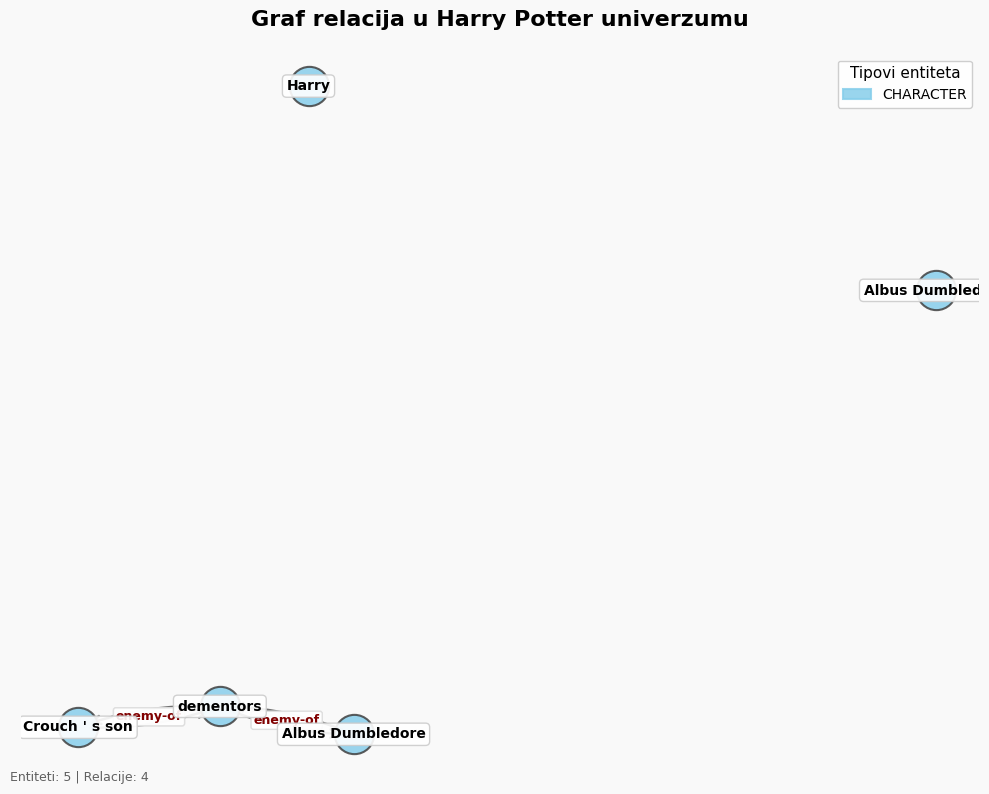

In [11]:
data = daj_sve("Harry started. He looked around. Then he looked on his other side. There was an Albus Dumbledore sitting on his right, watching Crouch's son being dragged away by the dementors - and there was an Albus Dumbledore on his left, looking right at him.")
PrikaziGraficki(data)

1
